In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

main_experiments_path = "../experiments"


basic_method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp_0.01",
    "mlp_0.001",
    "mlp_0.0001",
    "rbf_full_0.01",
    "rbf_full_0.001",
    "rbf_full_0.0001",
    "rbf_diag_0.01",
    "rbf_diag_0.001",
    "rbf_diag_0.0001",
    "rbf_scal_0.01",
    "rbf_scal_0.001",
    "rbf_scal_0.0001",
    "rbf_univ_0.01",
    "rbf_univ_0.001",
    "rbf_univ_0.0001",
    "ffn_0.1_0.01",
    "ffn_0.1_0.001",
    "ffn_0.1_0.0001",
    "ffn_1_0.01",
    "ffn_1_0.001",
    "ffn_1_0.0001",
    "ffn_10_0.01",
    "ffn_10_0.001",
    "ffn_10_0.0001",
    "uffn_0.1_0.01",
    "uffn_0.1_0.001",
    "uffn_0.1_0.0001",
    "uffn_1_0.01",
    "uffn_1_0.001",
    "uffn_1_0.0001",
    "uffn_10_0.01",
    "uffn_10_0.001",
    "uffn_10_0.0001",
]


basic_condensed_method_names = [
    "svr",
    "pls",
    "gradboost",
    "mlp",
    "rbf_full",
    "rbf_diag",
    "rbf_scal",
    "rbf_univ",
    "ffn",
    "uffn",
]

method_names = []
condensed_method_names = []
for i in range(2):
    method_names += [str(i+1)+"_"+method for method in basic_method_names]
    condensed_method_names += [str(i+1)+"_"+method for method in basic_condensed_method_names]


experiments_mean_df = pd.DataFrame()
experiments_std_df = pd.DataFrame()


method_settings = os.listdir(main_experiments_path)

# sort by name

method_settings = sorted(method_settings)

#print all folders in the main experiments path
for method_setting in method_settings:
    #print(method_setting)
    # iterate over repetitions

    experiment_df = pd.DataFrame()

    if method_setting.startswith("."):
        continue

    for repetition in os.listdir(main_experiments_path + "/" + method_setting):
        #print(repetition)
        # iterate over files

        if repetition.startswith("."):
            continue

        ## add this repetition to the experiment df as column
        experiment_df[repetition] = None

        try:
            ## read the npy file
            train_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition + "/data/" + "train_loss.npy")
            val_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition +  "/data/"  + "val_loss.npy")
            test_loss = np.load(main_experiments_path + "/" + method_setting + "/" + repetition + "/data/" + "test_loss.npy")
        except Exception as e:
            print("Error reading files for dataset: ", method_setting, e)
            continue
        
        ### extract the min val loss and pick the corresponding test loss

        min_val_loss = np.min(val_loss)
        min_val_loss_index = np.argmin(val_loss)

        min_test_loss = test_loss[min_val_loss_index]

    
        ## add the test loss to the experiment df
        experiment_df.loc["data",repetition] = min_test_loss

    ## order by dataset name
    experiment_df = experiment_df.sort_index()

    ## add a column which represents the mean of all repetitions
    experiment_df["mean"] = experiment_df.mean(axis=1)
    experiment_df["std"] = experiment_df.std(axis=1)

    #print(experiment_df)

    ## set mean to nan if there are any nans in the row
    experiment_df.loc[experiment_df.isnull().any(axis=1), "mean"] = np.nan

    ## add the experiment df to the experiments df
    experiments_mean_df[method_setting] = experiment_df["mean"]
    experiments_std_df[method_setting] = experiment_df["std"]


for i, method_name in enumerate(method_names):
    ## rename column experiment_000001 to method_names[0]
    exp_name = "experiment_" + str(i+1).zfill(6)
    experiments_mean_df = experiments_mean_df.rename(columns={exp_name: method_name})
    experiments_std_df = experiments_std_df.rename(columns={exp_name: method_name})

experiments_std_df



,1_svr,1_pls,1_gradboost,1_mlp_0.01,1_mlp_0.001,1_mlp_0.0001,1_rbf_full_0.01,1_rbf_full_0.001,1_rbf_full_0.0001,1_rbf_diag_0.01,...,2_ffn_10_0.0001,2_uffn_0.1_0.01,2_uffn_0.1_0.001,2_uffn_0.1_0.0001,2_uffn_1_0.01,2_uffn_1_0.001,2_uffn_1_0.0001,2_uffn_10_0.01,2_uffn_10_0.001,2_uffn_10_0.0001
data,0.0,0.0,0.0,0.47097,0.406998,0.245583,0.164881,0.066382,0.368822,0.185369,...,0.032418,3.670402,4.594322,3.672248,5.923679,7.006792,6.535965,2.757269,3.390368,3.549449


In [18]:
condensed_experiments_mean_df = pd.DataFrame()
condensed_experiments_std_df = pd.DataFrame()

## iterate over the condensed method names and pick the min test loss for the corresponding methods 
for condensed_method in condensed_method_names:

    min_idx = experiments_mean_df[[method for method in method_names if method.startswith(condensed_method)]].idxmin(axis=1)

    print(min_idx)

    condensed_experiments_mean_df[condensed_method] = experiments_mean_df[[method for method in method_names if method.startswith(condensed_method)]][min_idx]
    ### keep the std of the best method by the mean as the std of the condensed method 
    condensed_experiments_std_df[condensed_method] = experiments_std_df[[method for method in method_names if method.startswith(condensed_method)]][min_idx] 

## set all None to nan
condensed_experiments_mean_df = condensed_experiments_mean_df.replace({None: np.nan})
condensed_experiments_std_df = condensed_experiments_std_df.replace({None: np.nan})



### restructuring the dataframe to have the method names as columns and the indices as the rows the indices is the first part of the method name

condensed_experiments_mean_df = condensed_experiments_mean_df.T
condensed_experiments_mean_df = condensed_experiments_mean_df.reset_index()

condensed_experiments_mean_df["method"] = condensed_experiments_mean_df["index"].apply(lambda x: "_".join(x.split("_")[1:]))
condensed_experiments_mean_df["index"] = condensed_experiments_mean_df["index"].apply(lambda x: x.split("_")[0])


condensed_experiments_std_df = condensed_experiments_std_df.T
condensed_experiments_std_df = condensed_experiments_std_df.reset_index()

condensed_experiments_std_df["method"] = condensed_experiments_std_df["index"].apply(lambda x: "_".join(x.split("_")[1:]))
condensed_experiments_std_df["index"] = condensed_experiments_std_df["index"].apply(lambda x: x.split("_")[0])


## plot the index as the rows and method as the columns

condensed_experiments_mean_df = condensed_experiments_mean_df.pivot(index="index", columns="method")
condensed_experiments_std_df = condensed_experiments_std_df.pivot(index="index", columns="method")

## drop the index

condensed_experiments_mean_df.columns = condensed_experiments_mean_df.columns.droplevel(0)
condensed_experiments_std_df.columns = condensed_experiments_std_df.columns.droplevel(0)


condensed_experiments_mean_df

data    1_svr
dtype: object
data    1_pls
dtype: object
data    1_gradboost
dtype: object
data    1_mlp_0.001
dtype: object
data    1_rbf_full_0.001
dtype: object
data    1_rbf_diag_0.001
dtype: object
data    1_rbf_scal_0.001
dtype: object
data    1_rbf_univ_0.001
dtype: object
data    1_ffn_1_0.001
dtype: object
data    1_uffn_10_0.001
dtype: object
data    2_svr
dtype: object
data    2_pls
dtype: object
data    2_gradboost
dtype: object
data    2_mlp_0.001
dtype: object
data    2_rbf_full_0.001
dtype: object
data    2_rbf_diag_0.001
dtype: object
data    2_rbf_scal_0.001
dtype: object
data    2_rbf_univ_0.001
dtype: object
data    2_ffn_1_0.001
dtype: object
data    2_uffn_1_0.001
dtype: object


method,ffn,gradboost,mlp,pls,rbf_diag,rbf_full,rbf_scal,rbf_univ,svr,uffn
index,,,,,,,,,,
1,4.567468,0.018236,5.876619,0.026830,4.961287,4.961287,4.948212,4.504852,0.017827,4.424398
2,9.108123,0.037170,15.428970,0.051341,15.856319,15.856319,15.879264,11.859510,0.051508,8.056552


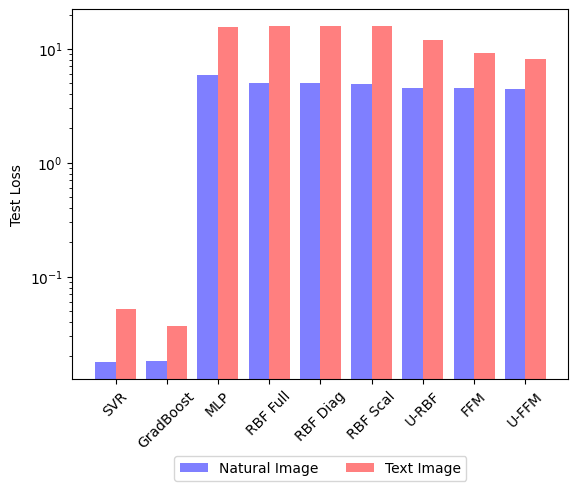

In [19]:

renamed_experiments_mean_df = condensed_experiments_mean_df.copy()
renamed_experiments_std_df = condensed_experiments_std_df.copy()

method_renaming = {
    "svr": "SVR",
    #"pls": "PLS",
    "gradboost": "GradBoost",
    "mlp": "MLP",
    "rbf_full": "RBF Full",
    "rbf_diag": "RBF Diag",
    "rbf_scal": "RBF Scal",
    "rbf_univ": "U-RBF",
    "ffn": "FFM",
    "uffn": "U-FFM",
}

## rename the methods and exclude methods whose names are not in the method_renaming dict

renamed_experiments_mean_df = renamed_experiments_mean_df.rename(columns=method_renaming)
renamed_experiments_mean_df = renamed_experiments_mean_df[method_renaming.values()]


renamed_experiments_std_df = renamed_experiments_std_df.rename(columns=method_renaming)
renamed_experiments_std_df = renamed_experiments_std_df[method_renaming.values()]


## plot the results in a line plot

# plt.figure(figsize=(10,5))
# plt.plot(renamed_experiments_df)
# plt.legend(renamed_experiments_df.columns)
# plt.xlabel("Noise Cut-Off Frequency")


### plot the results in a bar chart with two bars for each method one for the text image and one for the normal image
### the bars should be next to each other and the color should be different for the text and the normal image
### the x-axis is the method and the y-axis is the test loss
### the color of the bars is different for the text and the normal image


#plt.figure(figsize=(10,5))

#plt.bar(renamed_experiments_df.columns, renamed_experiments_df.loc["1",:], label="Text Image", color="blue", alpha=0.5)
#plt.bar(renamed_experiments_df.columns, renamed_experiments_df.loc["2",:], label="Normal Image", color="red", alpha=0.5)

plt.bar(np.arange(len(renamed_experiments_mean_df.columns))-0.2, renamed_experiments_mean_df.loc["1",:], label="Natural Image", color="blue", alpha=0.5, width=0.4)
plt.bar(np.arange(len(renamed_experiments_mean_df.columns))+0.2, renamed_experiments_mean_df.loc["2",:], label="Text Image", color="red", alpha=0.5, width=0.4)


plt.xticks(np.arange(len(renamed_experiments_mean_df.columns)), renamed_experiments_mean_df.columns, rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19), ncol=3)
#plt.xlabel("Method")


plt.ylabel("Test Loss")

# scale the y-axis to log

plt.yscale("log")

#plt.tight_layout()


plt.savefig("../../../assets/image_regression.pdf", format="pdf", bbox_inches='tight')

plt.show()



### plot 

In [21]:
## combine mean and std in one latex table

latex_table = pd.DataFrame()

for method in renamed_experiments_mean_df.columns:
    latex_table[method] = renamed_experiments_mean_df[method].apply(lambda x: "{:.2f}".format(x)) + " (±" + renamed_experiments_std_df[method].apply(lambda x: "{:.2f}".format(x)) + ")"

print(latex_table.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & SVR & GradBoost & MLP & RBF Full & RBF Diag & RBF Scal & U-RBF & FFM & U-FFM \\
index &  &  &  &  &  &  &  &  &  \\
\midrule
1 & 0.02 (±0.00) & 0.02 (±0.00) & 5.88 (±0.41) & 4.96 (±0.07) & 4.96 (±0.07) & 4.95 (±0.06) & 4.50 (±0.08) & 4.57 (±0.09) & 4.42 (±0.07) \\
2 & 0.05 (±0.00) & 0.04 (±0.00) & 15.43 (±0.63) & 15.86 (±4.05) & 15.86 (±4.05) & 15.88 (±4.08) & 11.86 (±5.58) & 9.11 (±6.65) & 8.06 (±7.01) \\
\bottomrule
\end{tabular}

